In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_rect_size = 1
max_rect_size = 4
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_rect_size, max_rect_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 2, 4))

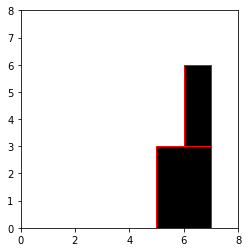

In [ ]:
import random
i = random.randint(1,1000)
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [ ]:
# Reshape and normalize the data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 8), 0.2814834375, 0.17521282872747532)

In [ ]:

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
filter_size = 3
pool_size = 2


model = Sequential([
        Dense(512, input_dim=X.shape[-1]),
        Activation('relu'),
        Dense(128, input_dim=X.shape[-1]),
        Activation('relu'),
        Dropout(0.2),
        Dense(y.shape[-1])
    ])

model.compile('adadelta', 'mse')

In [ ]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

In [ ]:
num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, epochs=1, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):    
        flipped_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + distance(pred_bboxes[4:], exp_bboxes[4:])
        dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + distance(pred_bboxes[4:], flipped_exp_bboxes[4:])

        if mse_flipped < mse:  # you can also use iou or dist here
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            mses_epoch[i, epoch] = mse_flipped / 2.
            ious_epoch[i, epoch] = iou_flipped / 2.
            dists_epoch[i, epoch] = dist_flipped / 2.
        else:
            mses_epoch[i, epoch] = mse / 2.
            ious_epoch[i, epoch] = iou / 2.
            dists_epoch[i, epoch] = dist / 2.

    print('Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    print('\n')

Epoch 0
1250/1250 - 3s - loss: 0.1383 - val_loss: 0.0813
Flipped 19891.0 training samples (49.7275 %)
Mean IOU: 0.037232690657124395
Mean dist: 0.35727365194077376
Mean mse: 0.033198528514804856


Epoch 1
1250/1250 - 2s - loss: 0.0888 - val_loss: 0.0656
Flipped 1721.0 training samples (4.3025 %)
Mean IOU: 0.05318151422847442
Mean dist: 0.3144863546827677
Mean mse: 0.025979474518208867


Epoch 2
1250/1250 - 3s - loss: 0.0741 - val_loss: 0.0569
Flipped 1114.0 training samples (2.785 %)
Mean IOU: 0.06598561365328626
Mean dist: 0.2901569431546851
Mean mse: 0.022127709409292335


Epoch 3
1250/1250 - 2s - loss: 0.0649 - val_loss: 0.0512
Flipped 948.0 training samples (2.37 %)
Mean IOU: 0.07684254374744041
Mean dist: 0.2736034593906058
Mean mse: 0.019633069058081792


Epoch 4
1250/1250 - 2s - loss: 0.0579 - val_loss: 0.0470
Flipped 905.0 training samples (2.2624999999999997 %)
Mean IOU: 0.08640724107200685
Mean dist: 0.2613253071013454
Mean mse: 0.01786833271362056


Epoch 5
1250/1250 - 2s - 

Text(0, 0.5, 'Training sample')

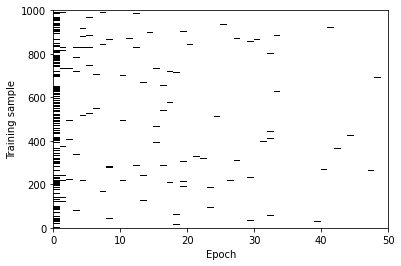

In [ ]:
plt.pcolor(flipped[:1000], cmap='Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0.0, 1.0)

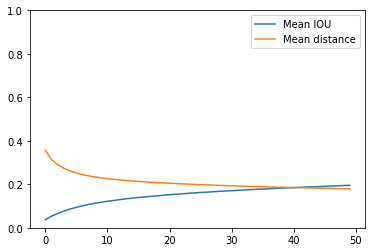

In [ ]:
plt.plot(np.mean(ious_epoch, axis=0), label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(np.mean(dists_epoch, axis=0), label='Mean distance')  # relative to image size
plt.legend()
plt.ylim(0, 1)


In [ ]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((10000, 2, 4), (10000, 2, 0))

[3.0901163  0.08360825 2.8350563  1.9934778 ]
[2.8934953  0.05177559 1.8182871  1.4411243 ]
[1.1641378 3.105485  1.7916882 1.2118427]
[1.9490995  4.0168724  0.78566885 0.8842524 ]
[ 5.314244   -0.78453827  2.0568438   1.9726627 ]
[2.9276226 3.003235  1.8148657 1.4338228]
[1.2816632 3.6937425 2.8126748 1.6420349]
[1.6368439 2.8688457 1.711059  2.524076 ]


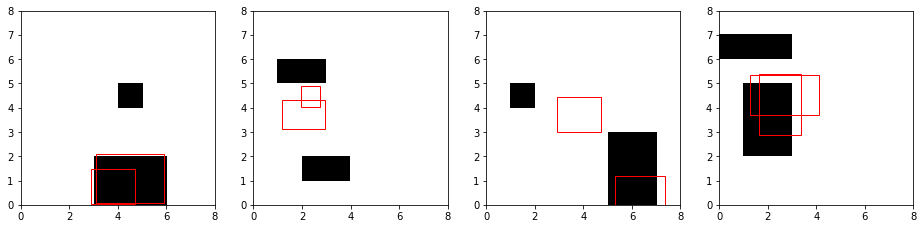

In [ ]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        print(pred_bbox)
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3],ec='r', fc='none'))